In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import cluster
import geopandas
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from scipy.stats import zscore

# Regional clustering using FB friendships

Another approach to this problem is to define regions by how connected people are between areas. It turns out Meta has an excellent [dataset](https://dataforgood.facebook.com/dfg/tools/social-connectedness-index) for this exact problem. Created by [Bailey et. al, 2018](https://www.aeaweb.org/articles?id=10.1257/jep.32.3.259), the dataset defines the social connectedness index as the proportion of friendships of users in one county with users in another county. Both in the original paper, and in excellent illustrations used in the [NYTimes write-up of the article](https://www.nytimes.com/interactive/2018/09/19/upshot/facebook-county-friendships.html), this was used to create some really cool data driven regions in the US.

To better understand how the regions were created, and to expand on this algorithm, let's first recreate the clustering procedure.

In [2]:
SCI_df = pd.read_csv('G:\My Drive\ds_projects\FB_socialconnectedness\county_county.tsv', sep='\t')
SCI_df.head()

,user_loc,fr_loc,scaled_sci
0,1001,1001,8946863
1,1001,1003,101997
2,1001,1005,134341
3,1001,1007,254620
4,1001,1009,67196


In [3]:
# To convert the 'social connectedness' measure to a distance measure, take its inverse
SCI_df['sci_distance'] = 1/SCI_df['scaled_sci']
SCI_df.head()

,user_loc,fr_loc,scaled_sci,sci_distance
0,1001,1001,8946863,1.117710e-07
1,1001,1003,101997,9.804210e-06
2,1001,1005,134341,7.443744e-06
3,1001,1007,254620,3.927421e-06
4,1001,1009,67196,1.488184e-05


In [4]:
# read in county_data, created by the cluster_regions_demographics script
county_data = pd.read_pickle(r'C:\Users\mgm24\Documents\datasets\county_data.pkl')
county_data.head()

,geometry,st,state,st_abbr,county,fips,location,area_sqmi,e_totpop,m_totpop,...,RegionName,DensityCat,DensityCatName,Population2016,Density2016_SqMi,Density2016_PFbF,DensityAggreg,center_long,center_lat,KMeans_cluster
0,"POLYGON ((-86.92120 32.65755, -86.92036 32.658...",1,ALABAMA,AL,Autauga,1001,"Autauga County, Alabama",594.446120,55049,0,...,01 Deep South,3,3 Rural/Semi-Rural,55416,925.973699,1.913169,100,-86.642748,32.534928,13
1,"POLYGON ((-86.96336 33.85823, -86.95967 33.857...",1,ALABAMA,AL,Blount,1009,"Blount County, Alabama",644.806508,57704,0,...,02 Appohzarka,3,3 Rural/Semi-Rural,57704,97.358358,0.201154,100,-86.567383,33.980878,7
2,"POLYGON ((-85.59344 32.89727, -85.59334 32.984...",1,ALABAMA,AL,Chambers,1017,"Chambers County, Alabama",596.531112,34018,0,...,01 Deep South,3,3 Rural/Semi-Rural,33843,355.276725,0.734043,100,-85.392033,32.914353,9
3,"POLYGON ((-86.19637 31.42544, -86.19396 31.440...",1,ALABAMA,AL,Coffee,1031,"Coffee County, Alabama",678.985652,50991,0,...,01 Deep South,3,3 Rural/Semi-Rural,51226,541.904065,1.119636,100,-85.988159,31.402652,7
4,"POLYGON ((-88.13925 34.58780, -88.13872 34.589...",1,ALABAMA,AL,Colbert,1033,"Colbert County, Alabama",592.619664,54377,0,...,02 Appohzarka,3,3 Rural/Semi-Rural,54216,768.079047,1.586940,100,-87.804934,34.700477,7


In [5]:
# Drop all values from sci_df not in county_data
todrop = list(set(np.unique(SCI_df['user_loc'])).difference(np.unique(county_data['fips'])))
SCI_df = SCI_df[~SCI_df['user_loc'].isin(todrop)]
SCI_df = SCI_df[~SCI_df['fr_loc'].isin(todrop)]

Now we have a measure defining the distance between each county, but using this in a clustering algorithm is not straightforward. In contrast to a variable like location which can be defined for an individual county, the social connectedness measure is always defined relative to another county. As a result, we need a clustering algorithm where we can input these relative distances, rather than a single measure for each county. The [agglomerative clustering](#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) algorithm fits the bill.

First, we'll need to create a pairwise distance matrix. We can then input this distance matrix by setting affinity to 'precomputed', and fitting with this matrix.

In [6]:
# To create a pairwise distance matrix, we can pivot this dataframe
sci_dist = pd.pivot(SCI_df, columns='fr_loc', values='sci_distance', index='user_loc')
sci_dist.head()

fr_loc,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
user_loc,,,,,,,,,,,,,,,,,,,,,
1001,1.117710e-07,9.804210e-06,7.443744e-06,3.927421e-06,1.488184e-05,2.330883e-06,0.000001,0.000014,0.000009,0.000028,...,0.000573,0.000597,0.000418,0.000810,0.000730,0.000561,0.000344,0.000731,0.001028,0.001453
1003,9.804210e-06,3.172975e-07,1.997443e-05,1.228879e-05,1.490024e-05,3.052969e-05,0.000006,0.000016,0.000025,0.000026,...,0.000805,0.000371,0.000298,0.000522,0.000279,0.000634,0.000158,0.000521,0.000717,0.000442
1005,7.443744e-06,1.997443e-05,2.212110e-08,3.133912e-05,5.388512e-05,1.598885e-07,0.000004,0.000018,0.000006,0.000060,...,0.000738,0.000713,0.001277,0.001645,0.001242,0.001695,0.000350,0.002358,0.001427,0.001580
1007,3.927421e-06,1.228879e-05,3.133912e-05,2.434424e-08,4.175470e-06,1.999440e-05,0.000008,0.000012,0.000028,0.000023,...,0.002273,0.000667,0.000647,0.001488,0.000774,0.001898,0.001058,0.001502,0.001391,0.001019
1009,1.488184e-05,1.490024e-05,5.388512e-05,4.175470e-06,7.533211e-08,7.212926e-05,0.000034,0.000005,0.000038,0.000006,...,0.002457,0.000709,0.000665,0.000320,0.001105,0.000487,0.000668,0.001079,0.000875,0.000513


In [7]:
# Merge together dataframes to make sure everything is aligned
county_conn = sci_dist.merge(county_data, left_on='user_loc', right_on='fips')

In [25]:
sci_dist.to_pickle(r'C:\Users\mgm24\Documents\datasets\sci_dist.pkl') 
# sci_dist.head()

In [13]:
# Run the clustering algorithm
clust_model = cluster.AgglomerativeClustering(n_clusters=10, affinity='precomputed', linkage='average') #linkage='complete' another option
clust_model.fit(sci_dist)

AgglomerativeClustering(affinity='precomputed', linkage='average',
                        n_clusters=10)

Text(0.5, 1.0, 'Social connectedness regions')

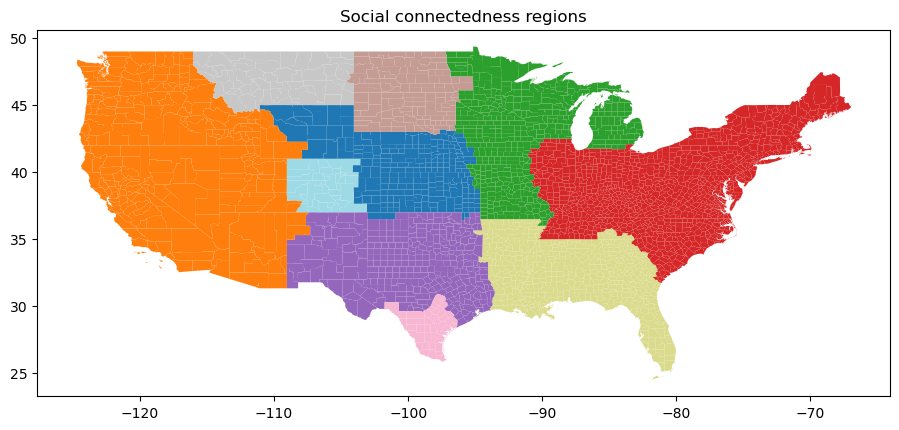

In [14]:
# Plot the results
county_conn = geopandas.GeoDataFrame(county_conn)
county_conn['Cluster'] = clust_model.labels_
county_conn.plot('Cluster', cmap='tab20', figsize=(11,10))
plt.title('Social connectedness regions')

This is similar to the figures in [NYTimes](https://www.nytimes.com/interactive/2018/09/19/upshot/facebook-county-friendships.html) and [Bailey et. al, 2018](https://www.aeaweb.org/articles?id=10.1257/jep.32.3.259). Potential differences could be from exluding Hawaii and Alaska here.

Now, let's try to expand on this method. In the *cluster_regions_demographics* script, I used both the geographical and demographic data for clustering, since regions should be defined both geographically and sociologically. Here, I'll include geographic data into the pairwise distance matrix, first on its own, and then averaged with the social distance index.

In [15]:
# Make a pairwise distance matrix for geographic distance

x = np.asarray(county_conn['center_long'])
y = np.asarray(county_conn['center_lat'])
coord_matrix = np.column_stack((x,y))

geo_dist = pairwise_distances(coord_matrix, metric='euclidean')

In [27]:
np.save(r'C:\Users\mgm24\Documents\datasets\geo_dist.npy', geo_dist)

Text(0.5, 1.0, 'Geographic distance regions')

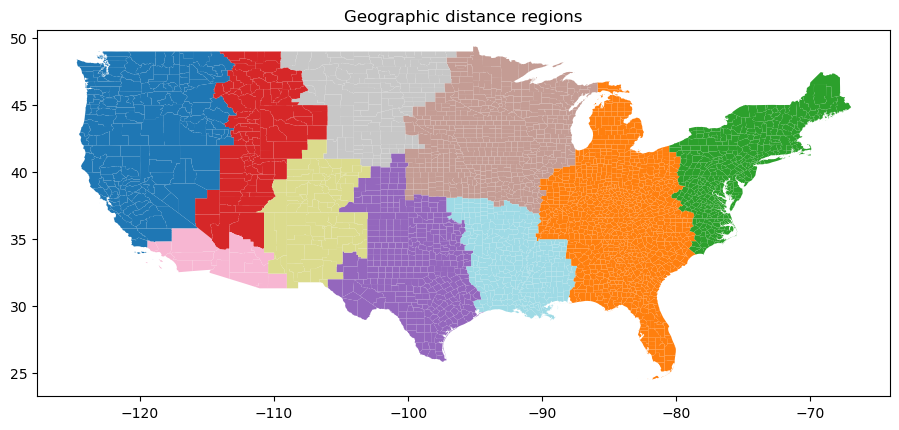

In [63]:
# Purely geographic clustering algorithm
clust_model = cluster.AgglomerativeClustering(n_clusters=10, affinity='precomputed', linkage='average') #linkage='complete' another option
clust_model.fit(geo_dist)
county_conn['Cluster'] = clust_model.labels_
county_conn.plot('Cluster', cmap='tab20', figsize=(11,10))
plt.title('Geographic distance regions')

The results look ok, but demonstrate a flaw of agglomerative clustering: cluster sizes often end up uneven.

Now, let's combine the social distance index with geographic distance:

Text(0.5, 1.0, 'Geographic + Social distance regions')

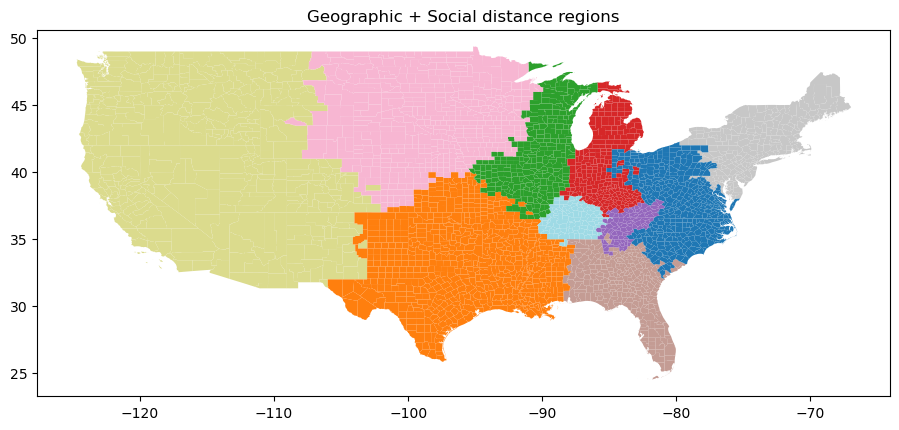

In [64]:
# Combine SDI and geographical distances

sci_dist = np.asarray(sci_dist)
sci_dist = zscore(sci_dist)
geo_dist = zscore(geo_dist)
comb_dist = sci_dist + geo_dist

clust_model.fit(comb_dist)
county_conn['Cluster'] = clust_model.labels_
county_conn.plot('Cluster', cmap='tab20', figsize=(11,10))
plt.title('Geographic + Social distance regions')

Overall, the social distance index is a very nice measure for clustering people together. 